# Programming for Quantitative Methods - Project

# Portfolio Theory

Konstantin Kudzuncic, Matthias Schuch & Orlando Saxer

## Introduction

In the first section of the project we give an introduction to portfolio theory and the benefits of diversification. We will construct a Markovitz Efficient Frontier step by step, using user-selected stocks and providing explanantions along the way.

In the next section, we dive deeper into modern portfolio theory.

## Dataset

We use the API from Quandl, which is an online marketplace for financial, economic and alternative data. Quandl offers a package for Python, but since it is not supported in Jupyter Notebook, we install it through pip. As a next step, the packages that will be needed in this notebook are loaded.

In [1]:
# Install the quandl pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install quandl

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [31]:
# Import needed modules
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pandas_datareader import data as pdr
#import fix_yahoo_finance as yf
import statsmodels.api as sm
from statsmodels import regression
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
import pylab 
import scipy.stats as stats
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

Populating the interactive namespace from numpy and matplotlib


## Markowitz Efficient Frontier

In this first part of our project, we will give a simple introduction to the theoretical concepts behind modern portfolio theory. Harry Markowitz can be considered the inventor of modern portfolio theory. He won the Nobel Prize in Economics in 1990. He wrote in 1952, that "since there were two criteria, risk and return, it was natural to assume that investors selected from the set of Pareto optimal risk-return combinations." Therefore, optimal portfolios can be constructed for any given level of risk an investor desires or can stomach. All these portfolios will lie on what is now known as the Markowitz Efficient Frontier.

We will now construct said Effient Frontier step-by-step using the Python code blocks below.

## Data Selection

The cell below allows to select stocks by their indices, as well as selecting a date range by defining starting and end dates. Additionally, the number of portfolios that should be created can be defined. (A longer date range, more stock indices, and higher number of portfolios will have an impact on computation time.) We select the stocks for Procter & Gamble, Johnson & Johnson, Walmart and McDonalds.

The code below imports the data through the Quandl API.

In [3]:
# Select stocks for portfolio. Other potential indices: 'NFLX', 'AMGN', 'GM', 'GD', 'TSLA', 'FB', 
stocks = ['PG', 'JNJ', 'WMT', 'MCD']

#Select starting and end date

starting_date = '2017-01-01'
end_date = '2017-12-31'

# Set number of portfolios

qty_portfolios = 50000

In [4]:
# Load data from Quandl

# Entering an API key allows unlimited downloads through the Quandl API
quandl.ApiConfig.api_key = '-4QgByxUyc4Wp2pUoTgo'

# Loading the data for the selected stocks
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = {'columns': ['date', 'ticker', 'adj_close']},
                        date = {'gte': starting_date, 'lte': end_date}, paginate=True)

# Loading the latest available risk free rate during selected time period
treasury_yield = quandl.get('USTREASURY/YIELD', qopts = {'columns': ['1 YR']}, start_date=starting_date, end_date=end_date, rows=1)

In [5]:
# Need to use treasury yield as risk free rate 

print(treasury_yield)

            1 MO  2 MO  3 MO  6 MO  1 YR  2 YR  3 YR  5 YR  7 YR  10 YR  \
Date                                                                      
2017-12-29  1.28  None  1.39  1.53  1.76  1.89  1.98   2.2  2.33    2.4   

            20 YR  30 YR  
Date                      
2017-12-29   2.58   2.74  


## Data Transformation and Initial Visualization

As a first step, the dataset is now cleaned up, visualized with a simple plot to confirm the data and some basic math operations are performed, since daily and annual returns and covariances will be needed in the next step.

In [6]:
# Set date as index
data_fixdate = data.set_index('date')

# Set stocks as columns
data_clean = data_fixdate.pivot(columns='ticker')

Text(0.5,0,'Date')

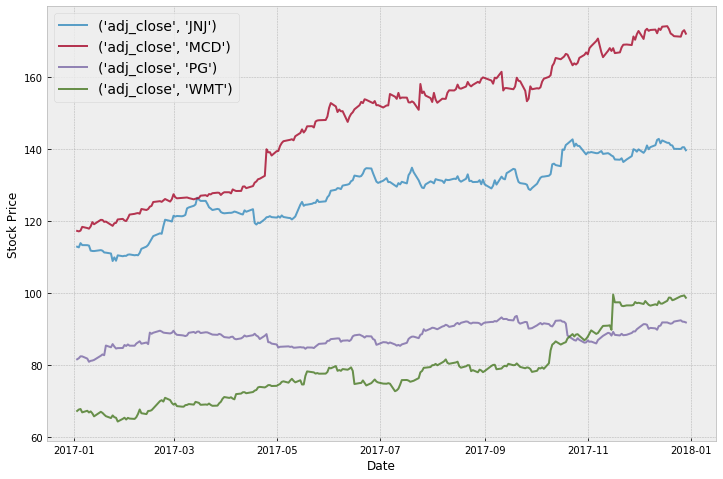

In [24]:
plt.figure(figsize=(12, 8))
for c in data_clean.columns.values:
    plt.plot(data_clean.index, data_clean[c], lw=2, alpha=0.8, label=c)
plt.legend(loc='upper left', fontsize=14)
plt.ylabel('Stock Price')
plt.xlabel('Date')

In [8]:
# Calculate daily and annual returns
daily_returns = data_clean.pct_change()
annual_returns = daily_returns.mean() * 252

# Calculate daily and annual covariance
daily_covariance = daily_returns.cov()
annual_covariance = daily_covariance * 252

## Determining portfolio weights, returns, volatility and Sharpe Ratio

In the next step we will focus on the calculations of the actual portfolios. Weights of the stock allocations for each portfolios are randomly generated, as well as return, volatility and Sharpe ratio of each portfolio are calculated. In a next step, the data is stored in a dataframe that can be used to vizualize the results.

In [9]:
# Create empty lists for returns, volatility and weights
portfolio_returns = []
portfolio_volatility = []
portfolio_weights = []
portfolio_sharperatio = []

In [10]:
# Calculate portfolio weights, returns, volatility and Sharpe Ratio and add to lists
for single_portfolio in range(qty_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    returns = np.dot(weights, annual_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(annual_covariance, weights)))
    sharperatio = returns / volatility
    # sharperatio = (returns-risk_free_rate) / volatility
    portfolio_returns.append(returns)
    portfolio_volatility.append(volatility)
    portfolio_weights.append(weights)
    portfolio_sharperatio.append(sharperatio)

In [11]:
# Create a dictionary for returns and corresponding volatility
portfolio_dict = {'Expected Returns': portfolio_returns,
             'Volatility': portfolio_volatility, 'Sharpe Ratio' : portfolio_sharperatio}

# Add ticker symbol and weight to dictionary
for counter,symbol in enumerate(stocks):
    portfolio_dict[symbol+' Weight'] = [Weight[counter] for Weight in portfolio_weights]
    
# Convert dictionary to a dataframe
df = pd.DataFrame(portfolio_dict)

# Rename and rearrange the columns
portfolio_df = df[['Expected Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in stocks]]

## Plotting the Portfolios

The randomly generated portfolios will now be visualized, which already provides us with a clear indication of the efficient frontier. A scatterplot is used to display the portfolios themselves, with a colormap indicating the Sharpe ratios of the various portfolios. A higher Sharpe ratio indicates a more effienct portfolio.

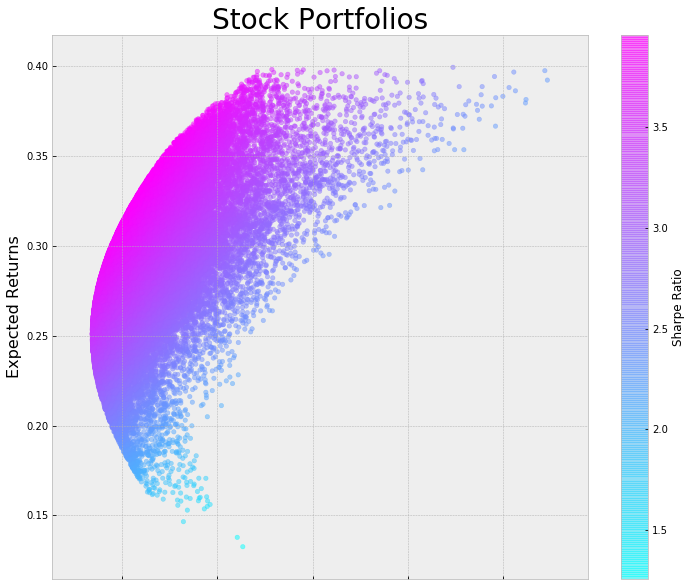

In [12]:
# Plot the portfolio with a color map for the Sharpe Ratio
plt.style.use('bmh')
portfolio_df.plot.scatter(x='Volatility', y='Expected Returns', c='Sharpe Ratio', cmap='cool', alpha=0.5, figsize=(12, 10), grid=True)
plt.xlabel('Standard Deviation', fontsize=16)
plt.ylabel('Expected Returns', fontsize=16)
plt.title('Stock Portfolios', fontsize=28)
plt.show()

## Plotting each stock



## Plotting special portfolios

Once we have plotted all the randomly generated portolios, it is worth taking a closer look at two special cases, the minimum variance portfolio and the most efficient portfolio. 

The minimum variance portfolio is the one that minimizes the risk, which means that it is the furthest towards the left in the graph. The most efficient portfolio is the one with the highest Sharpe ratio. We could more or less identify these portfolios by looking at the graph above, but we will vizualize them below.

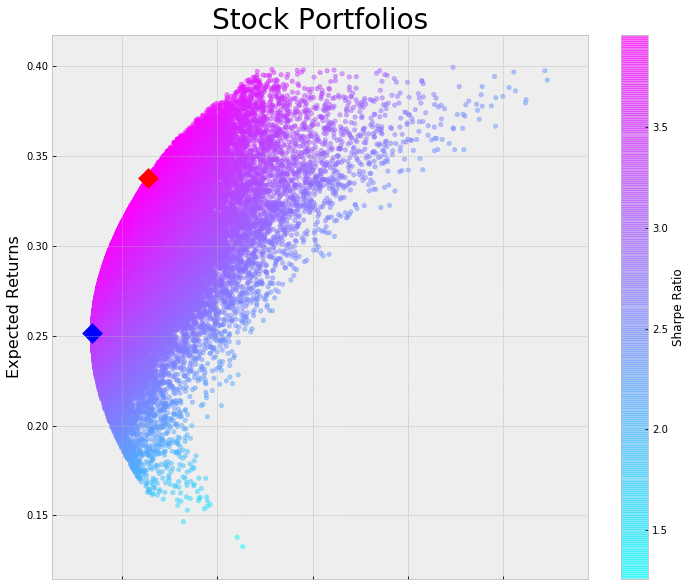

In [35]:
# Calculate special portfolios
min_portfolio_volatility = df['Volatility'].min()
min_variance_portfolio = df.loc[df['Volatility'] == min_portfolio_volatility]
max_portfolio_sharperatio = df['Sharpe Ratio'].max()
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_portfolio_sharperatio]

# Add special portfolios to previous plot
plt.style.use('bmh')
portfolio_df.plot.scatter(x='Volatility', y='Expected Returns', c='Sharpe Ratio', cmap='cool', alpha=0.5, figsize=(12, 10), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Expected Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_portfolio['Volatility'], y=min_variance_portfolio['Expected Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Standard Deviation', fontsize=16)
plt.ylabel('Expected Returns', fontsize=16)
plt.title('Stock Portfolios', fontsize=28)
plt.show()

## Plotting the Efficient Frontier



### Introduction to my part
Since we are exploring the Capital Asset Pricing Model and other adjunct topics in Modern Portfolio Theory, we will explain the underlying assumptions in the illustrated models. 
The Capital Asset Pricing Model is one of the most commonly used measures of cost of capital. It is based on the premise of diversification and the underlying distiction between systematic risk and idiosyncratic risk. We speek of diversification, when we combine investments of which the returns are not correlated. By doing that, in our portfolio of assets, we will have positions that will have positive returns and others with negative returns. The important thing is, that they don't move in tandem. To show the effects of diversification, we will explore an example. 

Asset 1 and 2 have an annualized returns of 20% and 40%, respectively. The variance of those returns is, 30% for asset 1 and 50% for asset 2. Considering the portfolio consists of 50% of Asset 1 and 50% of Asset 2, the annualized return of our holdings is 40% (The weighted average of the returns of the two assets. The variance of our portfolio will not necessarily be 40%, the weighted average of the two variances. Our overall variance depends on how the two assets are correlated. Mathematically, we have: 

$$\sigma^2_p = Var(w_1 A_1 + w_2 A_2) $$
$$ = Var(w_1 A_1) + Var(w_2 A_2) + 2 Cov(w_1 A_1,w_2 A_2) $$
$$ = w^2_1 Var(A_1) + w^2_1 Var(A_2) + 2 Cov(w_1 A_1,w_2 A_2) $$
$$ = w^2_1 Var(A_1) + w^2_1 Var(A_2) + 2 w_1 w_2\rho  \sigma_1  \sigma_2 $$

, where $\rho$ is the correlations coefficient between asset 1 and asset 2 and $\sigma$ is the respective standard deviation, respectively. At this point, here is a table that shows the variance of the portfolio under different correlation between assets 1 and 2: 

In [ ]:
var1 = 0.3
var2 = 0.5
sigma1 = 0.5477
sigma2 = 0.707
w1 = 0.5
w2 = 0.5
rho = np.array([-1, -0.5, 0, 0.5, 1])
var = (w1**2)*var1 + (w2**2)*var2 + 2*w1*w2*rho*sigma1*sigma2
print ('Portfolio Variance: ', var)
print ('Correlation coefficents: ', rho)

As the number of assets held in the portfolio increase, the overall risk of the portfolio declines. However, it does not tend towards zero, as there are certain risk, that cannot be diversified away in our setting. This makes us introduce the distinction between idiosyncratic risk and systematic risk. Idiosyncratic risk referes to the firm-specific risk, the risk that can be diversified away. Systematic risk is market-wide and affects all participants. 

So as our portfolio grows larger and and more independant bets are made through diversification, the variance declines. It declines to the point, where the portfolio variance equals the systamtic risk. Under this logic, we can conclude, that investors should not get compensated for taking idiosyncratic risk, but only for systamtic risk. In equation form, we have: 

$$ E[Return]=Risk-Free Rate of Return+Risk Premium $$ 

The expected return of an investment in any asset class can be decomposed into its constitutuent factors. Speaking of an investment in equities, we need to be compensated for taking systematic risk. After adjusting the risk premium for the codependance of the individual asset-class return with the overall market return, we have: 

$$ Risk Premium of Asseti=β(Market Risk Premium) $$

This is the CAPM model. We can further express it more accurately, as: 

$$ E[R_i]=R_F+ \beta (E[R_M]−R_F) $$

, where $R_F$ is the risk-free rate, $R_M$ is the expectedmarket return and $R_i$ is the individual expected asset return under the model. 

We can proceed to show the various betas for different sectors of the economy. We will work with the following sectors: Consumer Discretionary (XLY), Financials (XLF), Healthcare (XLV), Information Technology (XLK), Industrials (XLI), Materials (XLB), Energy (XLE) and  Utilities (XLU). As a proxy for the overall market we will use the S&P 500 Index (SPY). Note that, we are looking at sectors of the economy of the United States. 

Throughout this paper, we will also show multiple methods to import financial data into our notebook. It is often the case, that one database does not contain all the needed data, so that multiple sources need to be used. 

In [ ]:
# the old yahoo finance api does not work anymore, so this is the fix for it. 
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
# download Panel
data = pdr.get_data_yahoo(['XLY', 'XLF', 'XLV', 'XLK', 'XLP', 'XLI', 'XLB', 'XLE', 'XLU', 'SPY'], start="2013-12-01", end="2018-12-01")
rf_rate = pdr.get_data_yahoo('^IRX', start = '2013-01-01', end = '2018-12-01')

We now analyze the individual betas of the sectors. To run regressions, we first need to transform the end of day closing prices into daily returns. After doing that, we will use the CAPM model and run an OLS regression using the individual sector daily returns as predicted variable and the daily market returns as explanatory variable. 

In [ ]:
SPY_r = (data.Close['SPY'] - data.Close['SPY'].shift(1)) / data.Close['SPY'].shift(1)
SPY_r = SPY_r.dropna()

XLY_r = (data.Close['XLY'] - data.Close['XLY'].shift(1)) / data.Close['XLY'].shift(1)
XLY_r = XLY_r.dropna()

rf_rate.Close = rf_rate.Close / 100

In [ ]:
y = XLY_r - rf_rate.Close # <-- response
y = y.dropna()
X = SPY_r - rf_rate.Close # <-- predictor
X = X.dropna()

X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X)
results = model.fit()
XLY_beta = results.params[1]

XLY_r.plot(label='Daily Price Change XLY')
SPY_r.plot(label='Daily Price Change SPY')
rf_rate.Close.plot(label='3-month Treasury rate')
plt.xlabel('Time')
plt.ylabel('Daily Percent Return')
plt.legend();

print (XLY_beta)

results.summary()

From the results, we can see, that the Consumer Discreationary sector behaves similarly to the market on a daily basis. Analyzing how the daily performance of XLY covaries with the overall market indicates a statistically significant beta of 1. 

Securites with betas higher than 1, exhibit higher variations in returns than the overall market. If the market on any given day goes up by 1%, the price of the securities will tend to go up more than 1% on such given days. The converse is true, for betas lower than 1%. 

We can continue to calculate the betas for all the secotors. To show that betas are not static and change over time we calculate the 3-month (90 trading days) rolling betas.  

In [ ]:
data_return = (data.Close - data.Close.shift(1)) / data.Close.shift(1)
# We need to first clean up the data and put it into a better format to do our calculations
rdata = data_return.dropna()
rdata.head()

In [ ]:
sdata = rdata.drop(columns = ['SPY'])
sdata_stack = sdata.stack()
sdata_stack.head()


In [ ]:
sdata_stack = sdata.stack()
sdata_stack = sdata_stack.to_frame()
sdata_stack = sdata_stack.reset_index()
sdata_stack.columns = ['Date', 'asset', 'stock_returns']

sdata_stack.head()

In [ ]:
rdata = rdata.reset_index()
rdata.columns = ['Date', 'SPY','XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
print (list(rdata))
spy = rdata.drop(columns = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'] )
spy.head()

In [ ]:
merged_df = pd.merge(sdata_stack, spy, on='Date')
merged_df.columns = ['Date', 'asset', 'stock_returns', 'market_returns']
merged_df.tail()

In [ ]:
merged_df['stock_returns'].describe()

In [ ]:
merged_df = merged_df.sort_values(by = ['asset', 'Date'])
merged_df.head()

At this point we can calculate the rolling betas on our newly orgnaized dataframe. The function to calculate the beta is simple since we are using an OLS simple linear regression. 

$$ \beta_1 = Cov(stock returns, market returns) / Var(market returns) $$

We can also calculate the betas on different rolling periods. Here we show the 30, 60 and 90-Day rolling betas for our sectors. 

In [ ]:
merged_df['beta30'] = merged_df['stock_returns'].rolling(window=30).cov(other=merged_df['market_returns']) / merged_df['market_returns'].rolling(window=30).cov(other=merged_df['market_returns'])
merged_df['beta60'] = merged_df['stock_returns'].rolling(window=60).cov(other=merged_df['market_returns']) / merged_df['market_returns'].rolling(window=60).cov(other=merged_df['market_returns'])
merged_df['beta90'] = merged_df['stock_returns'].rolling(window=90).cov(other=merged_df['market_returns']) / merged_df['market_returns'].rolling(window=90).cov(other=merged_df['market_returns'])
merged_df.tail()

In [ ]:
plt.figure(1)
plt.subplot(521)
d1 = merged_df[merged_df.asset == 'XLU'].beta30.plot(label = '30-Day rolling beta Utilities (XLU)')
plt.legend()
plt.subplot(522)
d2 = merged_df[merged_df.asset == 'XLV'].beta30.plot(label = '30-Day rolling beta Healthcare (XLV)')
plt.legend()
plt.subplot(523)
d3 = merged_df[merged_df.asset == 'XLF'].beta30.plot(label = '30-Day rolling beta Financials (XLF)')
plt.legend()
plt.subplot(524)
d4 = merged_df[merged_df.asset == 'XLK'].beta30.plot(label = '30-Day rolling beta Technology (XLK)')
plt.legend()
plt.subplot(525)
d5 = merged_df[merged_df.asset == 'XLY'].beta30.plot(label = '30-Day rolling beta Consumer Discretionary (XLY)')
plt.legend()
plt.subplot(526)
d6 = merged_df[merged_df.asset == 'XLI'].beta30.plot(label = '30-Day rolling beta  Industrials (XLI)')
plt.legend()
plt.subplot(527)
d7 = merged_df[merged_df.asset == 'XLB'].beta30.plot(label = '30-Day rolling beta Materials (XLB)')
plt.legend()
plt.subplot(528)
d8 = merged_df[merged_df.asset == 'XLP'].beta30.plot(label = '30-Day rolling beta Consumer Staples (XLP)')
plt.legend()
plt.subplot(529)
d9 = merged_df[merged_df.asset == 'XLE'].beta30.plot(label = '30-Day rolling beta Energy (XLE)')
plt.legend()
plt.show()







In [ ]:
XLK_beta30 = merged_df[merged_df.asset == 'XLK'].beta30.plot(label = '30-Day rolling beta Technology (XLK)')
XLK_beta60 = merged_df[merged_df.asset == 'XLK'].beta60.plot(label = '60-Day rolling beta Technology (XLK)')
XLK_beta90 = merged_df[merged_df.asset == 'XLK'].beta90.plot(label = '90-Day rolling beta Technology (XLK)')
plt.legend()
plt.show()

In [ ]:
plt.figure(1)
plt.subplot(521)
d1 = merged_df[merged_df.asset == 'XLU'].beta60.plot(label = '60-Day rolling beta Utilities (XLU)')
plt.legend()
plt.subplot(522)
d2 = merged_df[merged_df.asset == 'XLV'].beta60.plot(label = '60-Day rolling beta Healthcare (XLV)')
plt.legend()
plt.subplot(523)
d3 = merged_df[merged_df.asset == 'XLF'].beta60.plot(label = '60-Day rolling beta Financials (XLF)')
plt.legend()
plt.subplot(524)
d4 = merged_df[merged_df.asset == 'XLK'].beta60.plot(label = '60-Day rolling beta Technology (XLK)')
plt.legend()
plt.subplot(525)
d5 = merged_df[merged_df.asset == 'XLY'].beta60.plot(label = '60-Day rolling beta Consumer Discretionary (XLY)')
plt.legend()
plt.subplot(526)
d6 = merged_df[merged_df.asset == 'XLI'].beta60.plot(label = '60-Day rolling beta  Industrials (XLI)')
plt.legend()
plt.subplot(527)
d7 = merged_df[merged_df.asset == 'XLB'].beta60.plot(label = '60-Day rolling beta Materials (XLB)')
plt.legend()
plt.subplot(528)
d8 = merged_df[merged_df.asset == 'XLP'].beta60.plot(label = '60-Day rolling beta Consumer Staples (XLP)')
plt.legend()
plt.subplot(529)
d9 = merged_df[merged_df.asset == 'XLE'].beta60.plot(label = '60-Day rolling beta Energy (XLE)')
plt.legend()
plt.show()


In [ ]:
plt.figure(1)
plt.subplot(521)
d1 = merged_df[merged_df.asset == 'XLU'].beta90.plot(label = '90-Day rolling beta Utilities (XLU)')
plt.legend()
plt.subplot(522)
d2 = merged_df[merged_df.asset == 'XLV'].beta90.plot(label = '90-Day rolling beta Healthcare (XLV)')
plt.legend()
plt.subplot(523)
d3 = merged_df[merged_df.asset == 'XLF'].beta90.plot(label = '90-Day rolling beta Financials (XLF)')
plt.legend()
plt.subplot(524)
d4 = merged_df[merged_df.asset == 'XLK'].beta90.plot(label = '90-Day rolling beta Technology (XLK)')
plt.legend()
plt.subplot(525)
d5 = merged_df[merged_df.asset == 'XLY'].beta90.plot(label = '90-Day rolling beta Consumer Discretionary (XLY)')
plt.legend()
plt.subplot(526)
d6 = merged_df[merged_df.asset == 'XLI'].beta90.plot(label = '90-Day rolling beta  Industrials (XLI)')
plt.legend()
plt.subplot(527)
d7 = merged_df[merged_df.asset == 'XLB'].beta90.plot(label = '90-Day rolling beta Materials (XLB)')
plt.legend()
plt.subplot(528)
d8 = merged_df[merged_df.asset == 'XLP'].beta90.plot(label = '90-Day rolling beta Consumer Staples (XLP)')
plt.legend()
plt.subplot(529)
d9 = merged_df[merged_df.asset == 'XLE'].beta90.plot(label = '90-Day rolling beta Energy (XLE)')
plt.legend()
plt.show()


### Calculation of correlation matrix

In [ ]:
# let us begin with initial downloaded data
sec = data.Close
sec_r = pd.DataFrame()
for stock in sec: 
    if stock not in sec_r: 
        sec_r[stock] = np.log(sec[stock]).diff()
sec_r.head()        

In [ ]:
sec_r.describe()

In [ ]:
sec_corr = sec_r.corr()
sec_corr

In [ ]:
# plot the heatmap and annotation on it with seaborn
sns.heatmap(sec_corr, xticklabels=sec_corr.columns, yticklabels=sec_corr.columns, annot=True)

In [ ]:
# 1 month rolling correlation of sectors to overall market (SPY)
rolling_corr20 = pd.DataFrame()
for stock in sec_r: 
    if stock not in rolling_corr20: 
        rolling_corr20[stock] = sec_r.SPY.rolling(window=20).corr(sec_r[stock])

# 3 month rolling correlation of sectors to overall market (SPY)
rolling_corr60 = pd.DataFrame()
for stock in sec_r: 
    if stock not in rolling_corr60: 
        rolling_corr60[stock] = sec_r.SPY.rolling(window=60).corr(sec_r[stock])

# 6 month rolling correlation of sectors to overall market (SPY)
rolling_corr120 = pd.DataFrame()
for stock in sec_r: 
    if stock not in rolling_corr120: 
        rolling_corr120[stock] = sec_r.SPY.rolling(window=120).corr(sec_r[stock])


In [ ]:
plt.figure(1)
plt.subplot(211)
p1 = sec.XLK.plot(color = 'blue', label = 'Technology XLK (lhs)', linewidth=1)
p2 = sec.SPY.plot(secondary_y = True, color = 'black', label = 'SPY Price (rhs)', linewidth=1)
plt.legend(loc=4)
plt.subplot(212)
p3 = rolling_corr20.XLK.plot(color = 'black', label = '20-Day rolling Correlation XLK vs. SPY', linewidth=1)
p4 = rolling_corr60.XLK.plot(color = 'blue', label = '60-Day rolling Correlation XLK vs. SPY', linewidth=1)
p5 = rolling_corr120.XLK.plot(color = 'magenta', label = '120-Day rolling Correlation XLK vs. SPY', linewidth=1)
plt.legend(loc=4)
plt.show()

## Volatility
Let us first look at the original data and then explore the concept of volatiltiy. This is essential to understand the assumption behind modern portfolio theory, CAPM and Efficient Frontiers. In all these Model, at least on the basic level (without looking at GARCH, FIGARCH and MMAR Models) it is assumed that the variance is finite and constant. We will now explore why this is not the case in reality and so why all these models do not work and the underlying assumptions need to be handicapped. 
We will be only looking at the general Stock market and not at individual securities. As a proxy for the overall stock market we will use the S&P 500 Index, a broad based market capitalization weighted index of the 500 largest companies in the United States. 

In [ ]:

data.Close['SPY'].plot(grid = True, color = 'green')
plt.xlabel('Date')
plt.ylabel('Daily Closing Price of S&P 500 Index')
plt.title('Original Data')
plt.legend(loc='upper left', fontsize=12)

In [ ]:
data.Close['SPY'].plot(color='red', grid=True, title='SPX realized variance',
         figsize=(16, 9))

In [ ]:
plt.hist(data.Close['SPY'], bins = 25)
plt.xlabel('nominal levels')
plt.ylabel('Frequency of daily Closing Price of S&P 500 Index')
plt.title('Original Data')


In [ ]:
stats.probplot(data.Close['SPY'], dist="norm", plot=pylab)
pylab.show()

In [ ]:
data.Close['SPY'].describe()

In [ ]:
result = seasonal_decompose(data.Close['SPY'], model='multiplicative', freq=1)
result.plot()
pyplot.show()

We will now transform the data and calculate the daily log returns of the S&P 500 Index. 

In [ ]:
# SPY['log_ret'] = np.log(SPY) - np.log(SPY.shift(1)) --> So daily LOG RETURNS

SPY_log = np.log(data.Close['SPY'])
SPY_log_shift = np.log(data.Close['SPY'].shift(1))
SPY_log_returns = SPY_log - SPY_log_shift


plt.plot(SPY_log_returns)

SPY_log_returns = SPY_log_returns.dropna()

In [ ]:
plt.hist(SPY_log_returns, bins = 25)
plt.ylabel('Frequency of S&P 500 log returns')
plt.title('Transformed Data')
# mu = np.mean(SPY_log_returns)
# sigma = np.std(SPY_log_returns)
# print (mu, sigma)
# import matplotlib.mlab as mlab
# bins = 25
# y = mlab.normpdf(bins, mu, sigma)
# print (y)
# l = plt.plot(bins, y, 'r--', linewidth=1)
plt.show()

In [ ]:
stats.probplot(SPY_log_returns, dist="norm", plot=pylab)
pylab.show()

In [ ]:
SPY_log_returns.describe()

In [ ]:
# note that hear we use the additive decomposition method, since there is no need to assume that with the passage of time the 
# daily variation of the prices will increase (no economic sense)

result = seasonal_decompose(SPY_log_returns, model='additive', freq=1)
result.plot()
pyplot.show()

## Example of instability of volatility

In [ ]:
import quandl

In [ ]:
df = quandl.get("VOL/MSFT", authtoken="yQLjrdqEbEEJy-eg-kpz")


In [ ]:
df.head()

In [ ]:
df.Hv10.plot(color = 'blue')
df.Hv20.plot(color = 'black')
df.Hv30.plot(color = 'magenta')
plt.xlabel('Date')
plt.ylabel('Historical volatility of Microsoft Stock Price on 10, 20, 30 day rolling basis')
plt.legend()

In [ ]:
df.Hv30.plot(color = 'black')
df.IvPut30.plot(color = 'blue')
plt.xlabel('Date')
plt.ylabel('30-Day historical Volatility of MSFT vs. 30-Day Put implied Volatiltiy') #<-- calculated through put options BS
plt.legend()

In [ ]:
vol_pd = (df.IvPut30 / df.Hv30)- 1
vol_pd = vol_pd.to_frame()
vol_pd.head()

In [ ]:
def _color_red_or_green(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

s = vol_pd.style.applymap(_color_red_or_green).format('{:.2%}')
s

In [ ]:
vol_pd_MA750 = vol_pd.rolling(window = 750).mean()
vol_pd_MA90 = vol_pd.rolling(window = 90).mean()
vol_pd_MA250 = vol_pd.rolling(window = 250).mean()
plt.plot(vol_pd, color = 'black', label = '30-Day Put implied vs. 30-Day historical volatility premium/discount')
plt.plot(vol_pd_MA90, color = 'magenta', label = '90-Day Moving Average' )
plt.plot(vol_pd_MA250, color = 'blue', label = '250-Day Moving Average');
plt.legend()

In [ ]:
vol_pd.describe()

We can use the Sapiro-Wilk Test, among many, to see if the data satisfies a Gaussian distribution. Before we have visually seen that this is not the case. The result from the test also indicate that the implied volatility premium/discount is not normally distributed. The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.

In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.

The shapiro() SciPy function will calculate the Shapiro-Wilk on a given dataset. The function returns both the W-statistic calculated by the test and the p-value.

In [ ]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro

# normality test
stat, p = shapiro(vol_pd.dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')



In [ ]:
import warnings; warnings.simplefilter('ignore')
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.mlab import stineman_interp
import pandas as pd
from pandas_datareader import data, wb
import requests
import zipfile as zi 
import io
from sklearn import datasets, linear_model
import scipy.special as scsp
import statsmodels.api as sm
import math
import seaborn as sns; sns.set()
%matplotlib inline

In [ ]:
url = 'https://realized.oxford-man.ox.ac.uk/images/'
url += 'oxfordmanrealizedvolatilityindices-0.2-final.zip'
data = requests.get(url, stream=True).content
z = zi.ZipFile(io.BytesIO(data))
z.extractall()

In [ ]:
df = pd.read_csv('OxfordManRealizedVolatilityIndices.csv', index_col=0, header=2 )
rv1 = pd.DataFrame(index=df.index)
for col in df.columns:
    if col[-3:] == '.rk':
        rv1[col] = df[col]
rv1.index = [dt.datetime.strptime(str(date), "%Y%m%d") for date in rv1.index.values]

In [ ]:
spx = pd.DataFrame(rv1['SPX2.rk'])
spx.plot(color='red', grid=True, title='SPX realized variance',
         figsize=(16, 9), ylim=(0,0.003));

In [ ]:
spx.head()

In [ ]:
spx.tail()

In [ ]:
from pandas_datareader import data as pdr

import fix_yahoo_finance as yf
yf.pdr_override()

SPX = pdr.get_data_yahoo('^GSPC', start = '2000-01-01')
SPX = SPX['Adj Close']
SPX.plot(title='SPX',figsize=(14, 8));

In [ ]:
type(SPX)

In [ ]:
def calc_beta(df):
    np_array = df.values
    s = np_array[:,0] # stock returns are column zero from numpy array
    m = np_array[:,1] # market returns are column one from numpy array

    covariance = np.cov(s,m) # Calculate covariance between stock and market
    beta = covariance[0,1]/covariance[1,1]
    return beta

def rolling_apply(df, period, func, min_periods=None):
    if min_periods is None:
        min_periods = period
    result = pd.Series(np.nan, index=df.index)

    for i in range(1, len(df)+1):
        sub_df = df.iloc[max(i-period, 0):i,:] #I edited here
        if len(sub_df) >= min_periods:
            idx = sub_df.index[-1]
            result[idx] = func(sub_df)
    return result

df['beta'] = np.nan
grp = df.groupby('id')
period = 6 #I'm using 6  to see some not NaN values, since sample data don't have longer than 12 groups
for stock, sub_df in grp:
    beta = rolling_apply(sub_df[['ret_1m','mkt_ret_1m']], period, calc_beta, min_periods = period)  
    beta.name = 'beta'
    df.update(beta)
print df
Output